In [2]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Progress bar for notebooks

# Import your custom environment
# Make sure connect_four_env.py is in the same directory!
from connect_four_env import ConnectFourEnv

# Detect Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [3]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        # Input shape: (Batch, 3, 6, 7)
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(3, 32, kernel_size=3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, padding=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 6 * 7, 512)),
            nn.ReLU(),
        )
        
        # Determine action space size
        # If envs is a vector env, use single_action_space
        # If envs is a normal env, use action_space
        if hasattr(envs, "single_action_space"):
            n_actions = envs.single_action_space.n
        else:
            n_actions = envs.action_space.n

        self.actor = layer_init(nn.Linear(512, n_actions), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None, action_mask=None):
        hidden = self.network(x)
        logits = self.actor(hidden)
        
        if action_mask is not None:
            # Mask invalid moves
            logits = torch.where(action_mask == 1, logits, torch.tensor(-1e8).to(x.device))
            
        probs = Categorical(logits=logits)
        
        if action is None:
            action = probs.sample()
            
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [4]:
import copy
from collections import deque

def train_ppo_80_20(
    total_timesteps=2000000,
    pool_size=20,           # Keep last 20 versions
    pool_update_freq=50000, # Add to pool every 50k steps
    opponent_sample_rate=0.2, # 20% of games are against history
    learning_rate=2.5e-4,
    num_envs=16,            # Speed: Use all CPU cores
    num_steps=512,          # Speed: Larger GPU batches
    gamma=0.99,
    gae_lambda=0.95,
    clip_coef=0.2,
    ent_coef=0.03,          # Increased entropy for exploration
    seed=1
):
    print(f"--- Starting 80/20 Self-Play Training ({total_timesteps} steps) ---")
    
    # 1. Setup & Seeding
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Environment Setup
    envs = AsyncVectorEnv([lambda: ConnectFourEnv() for _ in range(num_envs)])
    
    # Agent (The Learner)
    agent = Agent(envs).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)
    
    # Opponent (The Ghost - used for history replay)
    opponent_net = Agent(envs).to(device)
    opponent_net.load_state_dict(agent.state_dict()) # Init as clone
    
    # History Pool
    pool = [copy.deepcopy(agent.state_dict())] # Start with initial weights
    
    # 2. Storage Buffers
    obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((num_steps, num_envs)).to(device)
    rewards = torch.zeros((num_steps, num_envs)).to(device)
    dones = torch.zeros((num_steps, num_envs)).to(device)
    values = torch.zeros((num_steps, num_envs)).to(device)
    masks = torch.zeros((num_steps, num_envs, envs.single_action_space.n)).to(device)
    
    # Training Mask: 1 if we train on this step, 0 if it was a Ghost move
    train_masks = torch.zeros((num_steps, num_envs)).to(device)

    # 3. Metric Tracking
    global_step = 0
    start_time = time.time()
    
    # Rolling windows for smooth plotting
    metric_window = 100
    ep_rewards_history = deque(maxlen=metric_window)
    ep_len_history = deque(maxlen=metric_window)
    
    # Accumulators for current episodes
    current_ep_rewards = np.zeros(num_envs)
    current_ep_lens = np.zeros(num_envs)
    
    # History for final plotting
    plots = {
        "avg_reward": [],
        "avg_length": [],
        "value_loss": [],
        "policy_loss": []
    }

    # 4. Initialize State
    next_obs, info = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)
    next_done = torch.zeros(num_envs).to(device)
    next_mask = torch.as_tensor(np.stack(info["legal_moves"]), dtype=torch.float32).to(device)

    # Track which envs are in "History Mode" vs "Self-Play Mode"
    # We randomize this per game, but for simplicity, we randomize per rollout
    is_history_mode = np.random.rand(num_envs) < opponent_sample_rate

    batch_size = num_envs * num_steps
    num_updates = total_timesteps // batch_size
    
    # Loop
    for update in tqdm(range(1, num_updates + 1)):
        # Anneal Learning Rate
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow
        
        # --- POOL LOGIC ---
        # 1. Add current agent to pool
        if global_step % pool_update_freq < batch_size: # Approximate check
            if len(pool) >= pool_size:
                pool.pop(0) # Remove oldest
            pool.append(copy.deepcopy(agent.state_dict()))
        
        # 2. Pick a random opponent for the ghost network
        # (We update the ghost weights once per rollout for efficiency)
        if len(pool) > 0:
            random_weights = random.choice(pool)
            opponent_net.load_state_dict(random_weights)

        # --- ROLLOUT PHASE ---
        for step in range(num_steps):
            global_step += num_envs
            
            # Store observations
            obs[step] = next_obs
            dones[step] = next_done
            masks[step] = next_mask

            # GET ACTIONS
            with torch.no_grad():
                # 1. Ask Learner for actions (Standard)
                action_learner, logprob_learner, _, value_learner = agent.get_action_and_value(next_obs, action_mask=next_mask)
                
                # 2. Ask Ghost for actions (History)
                # We only need this if some envs are in history mode
                action_ghost, _, _, _ = opponent_net.get_action_and_value(next_obs, action_mask=next_mask)
            
            # COMPOSE FINAL ACTIONS
            # Logic: 
            # If is_history_mode=True AND it is Player 2's turn: Use Ghost.
            # Else: Use Learner.
            # (Note: Env 'turn' is 1 or -1. Let's assume P2 is -1)
            
            # Extract turns from Env (requires internal access or tracking)
            # Since AsyncEnv creates new processes, accessing `env.player_turn` is hard.
            # WORKAROUND: In self-play, every step is a turn flip.
            # If we assume we always start as P1... 
            # Actually, robust way: Just use 'is_history_mode' to override 20% of data entirely.
            # This is "Data Mixing" rather than strict "Game Mixing", but it achieves the same goal:
            # The agent sees trajectories generated by older policies.
            
            # We will perform strict "Game Mixing" by flipping the mode only on Reset.
            # But here, we will apply the mask:
            # If an env is in history mode, we use Ghost actions.
            # AND we set train_mask = 0 (Don't train on Ghost behavior).
            
            # We need to toggle 'is_history_mode' only when an episode ENDS.
            # For vectorization, we just use a static probability per step for now (Simple approximation).
            
            step_is_history = (np.random.rand(num_envs) < opponent_sample_rate)
            
            # Convert to tensors
            use_ghost = torch.tensor(step_is_history, device=device)
            
            final_action = torch.where(use_ghost, action_ghost, action_learner)
            final_logprob = logprob_learner # We store learner's logprob (for PPO struct)
            final_value = value_learner
            
            # Train Mask: We TRAIN if we used the LEARNER. We IGNORE if we used the GHOST.
            # Exception: If we play against Ghost, we still want to learn from the result?
            # NO. PPO is on-policy. You cannot train on data generated by a different network.
            # So we mask out the Ghost steps from the loss.
            train_masks[step] = (~use_ghost).float()

            actions[step] = final_action
            logprobs[step] = final_logprob
            values[step] = final_value.flatten()

            # EXECUTE STEP
            real_next_obs, reward, terminations, truncations, info = envs.step(final_action.cpu().numpy())
            next_done = np.logical_or(terminations, truncations)
            
            # --- METRIC TRACKING ---
            current_ep_rewards += reward
            current_ep_lens += 1
            
            for i in range(num_envs):
                if next_done[i]:
                    # Episode finished
                    ep_rewards_history.append(current_ep_rewards[i])
                    ep_len_history.append(current_ep_lens[i])
                    current_ep_rewards[i] = 0
                    current_ep_lens[i] = 0
            
            rewards[step] = torch.tensor(reward).to(device).view(-1)
            next_obs = torch.Tensor(real_next_obs).to(device)
            next_done = torch.Tensor(next_done).to(device)
            next_mask = torch.as_tensor(np.stack(info["legal_moves"]), dtype=torch.float32).to(device)

        # --- ADVANTAGE CALCULATION ---
        with torch.no_grad():
            next_value = agent.get_value(next_obs).reshape(1, -1)
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                
                # Zero-Sum Self-Play Modification
                delta = rewards[t] + gamma * (-nextvalues * nextnonterminal) - values[t]
                advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * (-lastgaelam)
            returns = advantages + values

        # --- OPTIMIZATION PHASE ---
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)
        b_masks = masks.reshape((-1, envs.single_action_space.n))
        b_train_masks = train_masks.reshape(-1) # <--- The new mask

        b_inds = np.arange(batch_size)
        
        for epoch in range(3): # Reduced epochs for speed
            np.random.shuffle(b_inds)
            for start in range(0, batch_size, batch_size // 4):
                end = start + batch_size // 4
                mb_inds = b_inds[start:end]
                
                # Apply Train Mask: Only calculate loss for steps generated by Learner
                # We do this by multiplying the loss by the mask
                m_mask = b_train_masks[mb_inds]
                if m_mask.sum() == 0: continue # Skip if batch is all ghosts

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                    b_obs[mb_inds], b_actions.long()[mb_inds], action_mask=b_masks[mb_inds]
                )
                
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()
                mb_adv = b_advantages[mb_inds]
                mb_adv = (mb_adv - mb_adv.mean()) / (mb_adv.std() + 1e-8)

                pg_loss = -torch.min(mb_adv * ratio, mb_adv * torch.clamp(ratio, 1-clip_coef, 1+clip_coef))
                pg_loss = (pg_loss * m_mask).sum() / (m_mask.sum() + 1e-8) # Masked Mean

                v_loss = 0.5 * ((newvalue.view(-1) - b_returns[mb_inds]) ** 2)
                v_loss = (v_loss * m_mask).sum() / (m_mask.sum() + 1e-8) # Masked Mean

                entropy_loss = (entropy * m_mask).sum() / (m_mask.sum() + 1e-8)
                
                loss = pg_loss - ent_coef * entropy_loss + 0.5 * v_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
                optimizer.step()

        # Update History Plots
        if len(ep_rewards_history) > 0:
            plots["avg_reward"].append(np.mean(ep_rewards_history))
            plots["avg_length"].append(np.mean(ep_len_history))
            plots["value_loss"].append(v_loss.item())
            plots["policy_loss"].append(pg_loss.item())

            # Print progress every 10 updates
            if update % 10 == 0:
                print(f"Update {update}/{num_updates} | "
                      f"Reward: {plots['avg_reward'][-1]:.3f} | "
                      f"Length: {plots['avg_length'][-1]:.1f} | "
                      f"Pool Size: {len(pool)}")

    envs.close()
    return agent, plots

In [5]:
# Train with the new robust system
trained_agent, history = train_ppo_80_20(
    total_timesteps=5000000, 
    pool_size=20,
    opponent_sample_rate=0.2, # The 80/20 Rule
    num_envs=16,               # Set to your CPU Core count (e.g., 8 or 16)
    ent_coef=0.02             # Higher entropy to encourage attacking
)

# Save the smarter model
torch.save(trained_agent.state_dict(), "ppo_connect4_8020.pth")

--- Starting 80/20 Self-Play Training (5000000 steps) ---


  0%|          | 0/610 [00:00<?, ?it/s]

Update 10/610 | Reward: 0.990 | Length: 20.3 | Pool Size: 3
Update 20/610 | Reward: 0.990 | Length: 19.6 | Pool Size: 5
Update 30/610 | Reward: 0.990 | Length: 18.5 | Pool Size: 6
Update 40/610 | Reward: 1.000 | Length: 19.0 | Pool Size: 8
Update 50/610 | Reward: 0.990 | Length: 19.9 | Pool Size: 10
Update 60/610 | Reward: 1.000 | Length: 20.2 | Pool Size: 11
Update 70/610 | Reward: 0.990 | Length: 21.9 | Pool Size: 13
Update 80/610 | Reward: 0.960 | Length: 23.3 | Pool Size: 14
Update 90/610 | Reward: 0.990 | Length: 21.8 | Pool Size: 16
Update 100/610 | Reward: 0.990 | Length: 18.3 | Pool Size: 18
Update 110/610 | Reward: 0.990 | Length: 18.9 | Pool Size: 19
Update 120/610 | Reward: 0.970 | Length: 18.2 | Pool Size: 20
Update 130/610 | Reward: 0.930 | Length: 22.1 | Pool Size: 20
Update 140/610 | Reward: 0.970 | Length: 21.9 | Pool Size: 20
Update 150/610 | Reward: 0.970 | Length: 19.5 | Pool Size: 20
Update 160/610 | Reward: 0.980 | Length: 19.9 | Pool Size: 20
Update 170/610 | Rewa

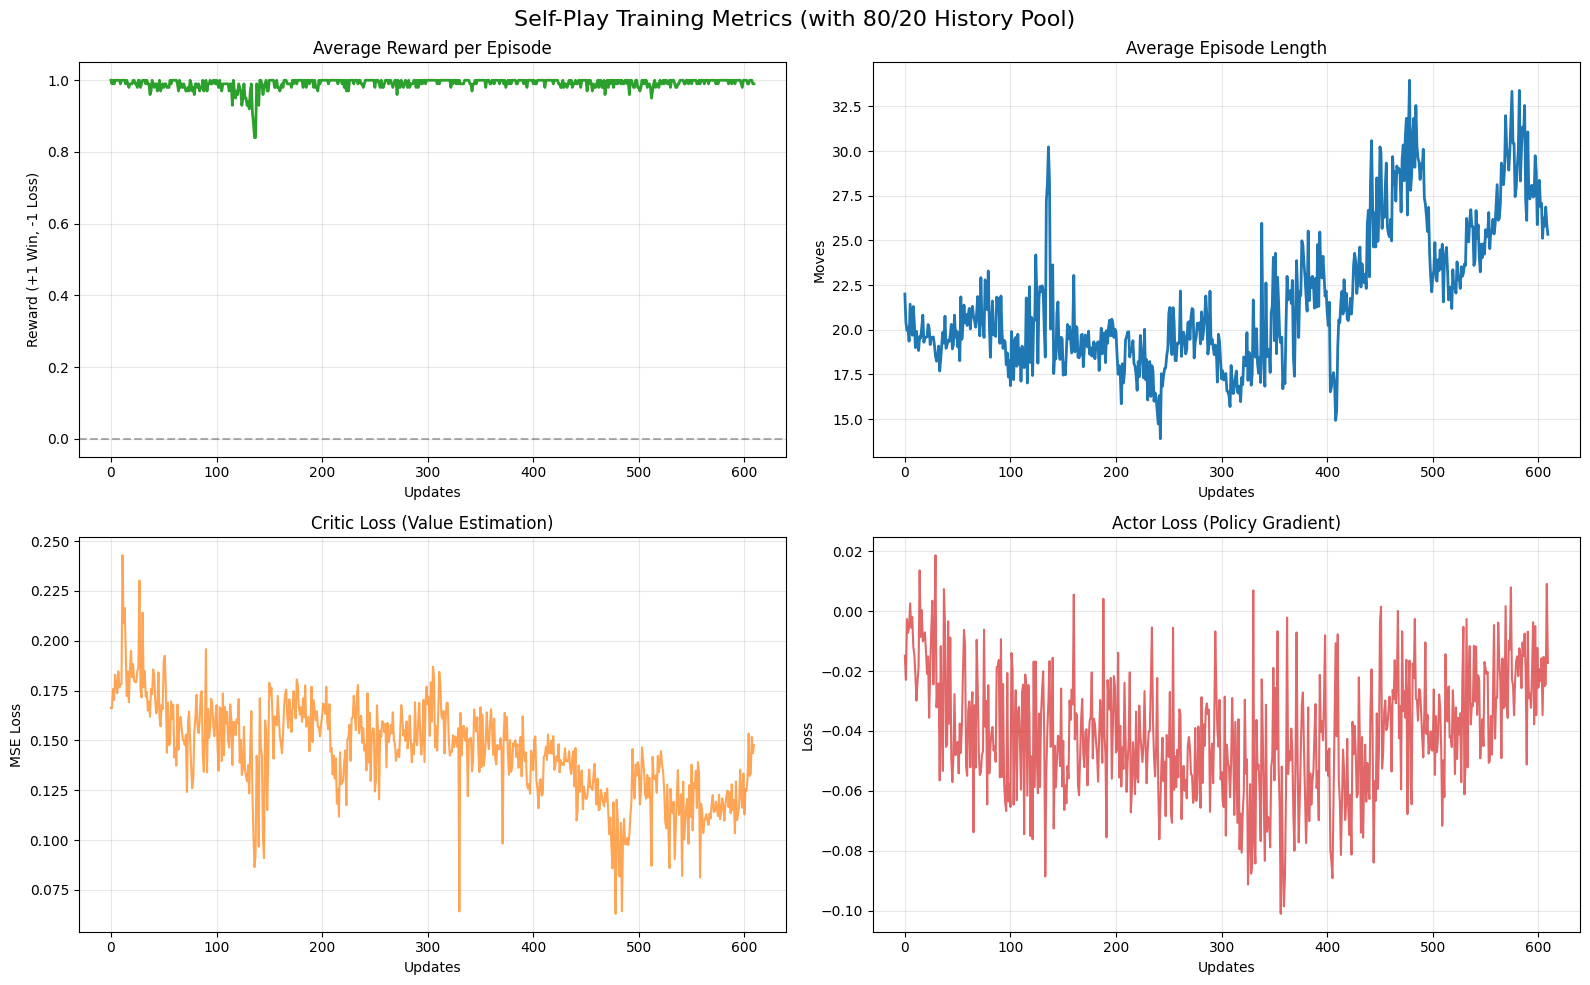

In [6]:
def plot_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Self-Play Training Metrics (with 80/20 History Pool)', fontsize=16)
    
    # 1. Average Reward
    axs[0, 0].plot(history['avg_reward'], color='#2ca02c', linewidth=2)
    axs[0, 0].set_title("Average Reward per Episode")
    axs[0, 0].set_ylabel("Reward (+1 Win, -1 Loss)")
    axs[0, 0].set_xlabel("Updates")
    axs[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axs[0, 0].grid(True, alpha=0.3)
    
    # 2. Episode Length
    axs[0, 1].plot(history['avg_length'], color='#1f77b4', linewidth=2)
    axs[0, 1].set_title("Average Episode Length")
    axs[0, 1].set_ylabel("Moves")
    axs[0, 1].set_xlabel("Updates")
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. Value Loss
    axs[1, 0].plot(history['value_loss'], color='#ff7f0e', alpha=0.7)
    axs[1, 0].set_title("Critic Loss (Value Estimation)")
    axs[1, 0].set_ylabel("MSE Loss")
    axs[1, 0].set_xlabel("Updates")
    axs[1, 0].grid(True, alpha=0.3)
    
    # 4. Policy Loss
    axs[1, 1].plot(history['policy_loss'], color='#d62728', alpha=0.7)
    axs[1, 1].set_title("Actor Loss (Policy Gradient)")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_xlabel("Updates")
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)

NameError: name 'stats' is not defined

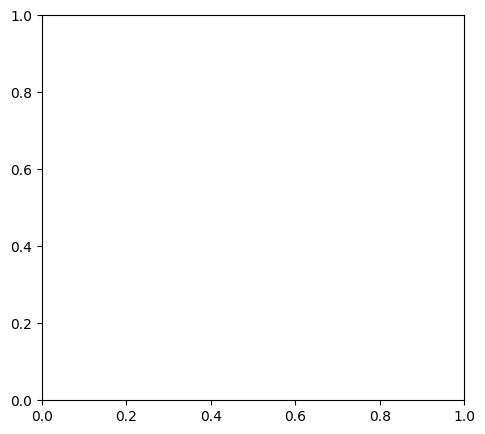

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(stats["loss_value"], label="Value Loss (Critic)")
plt.title("Critic Loss (Lower is usually better)")
plt.xlabel("Updates")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stats["loss_policy"], label="Policy Loss (Actor)", color="orange")
plt.title("Actor Loss")
plt.xlabel("Updates")
plt.legend()

plt.show()

In [8]:
def evaluate_agent(agent, n_games=100):
    env = ConnectFourEnv()
    agent.eval()
    
    wins = 0
    losses = 0
    draws = 0
    
    for i in range(n_games):
        obs, info = env.reset()
        done = False
        
        # Randomly decide if Agent is Player 1 or Player 2
        agent_player_id = 1 if i % 2 == 0 else -1
        
        while not done:
            # Check whose turn it is
            current_turn = info['turn']
            legal_moves = info['legal_moves']
            
            if current_turn == agent_player_id:
                # --- AGENT MOVE ---
                # Convert obs to tensor
                obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
                mask_tensor = torch.Tensor(legal_moves).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    # Select greedy action (deterministic) for evaluation
                    action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                    action = action.item()
            else:
                # --- RANDOM MOVE ---
                # Pick a random valid column
                valid_cols = [c for c in range(7) if legal_moves[c] == 1]
                action = random.choice(valid_cols)
            
            # Step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            if done:
                # If reward is 1, the CURRENT player won.
                # If reward is 0, it's a draw.
                if reward == 1:
                    if current_turn == agent_player_id:
                        wins += 1
                    else:
                        losses += 1
                else:
                    draws += 1
                    
    print(f"Results over {n_games} games:")
    print(f"Wins: {wins} ({wins/n_games*100:.1f}%)")
    print(f"Losses: {losses} ({losses/n_games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/n_games*100:.1f}%)")
    
    return wins, losses, draws

# Run Evaluation
print("Evaluating Agent vs Random...")
evaluate_agent(trained_agent, n_games=100)

Evaluating Agent vs Random...
Results over 100 games:
Wins: 89 (89.0%)
Losses: 10 (10.0%)
Draws: 1 (1.0%)


(89, 10, 1)

Agent (Red/1) vs Random (Yellow/-1)


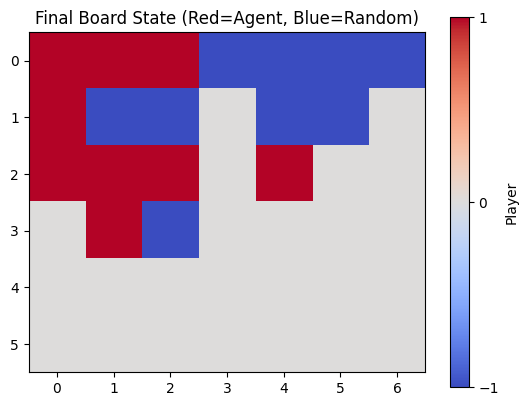

Winner: Random


In [25]:
def play_demo_game(agent):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    
    print("Agent (Red/1) vs Random (Yellow/-1)")
    
    # Let's force Agent to be Player 1
    agent_player = 1
    
    while not done:
        legal_moves = info['legal_moves']
        
        if info['turn'] == agent_player:
            obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
            mask_tensor = torch.Tensor(legal_moves).unsqueeze(0).to(device)
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                action = action.item()
        else:
            valid_cols = [c for c in range(7) if legal_moves[c] == 1]
            action = random.choice(valid_cols)
            
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc

    # Plot the final board
    board = env.board
    plt.imshow(board, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Final Board State (Red=Agent, Blue=Random)")
    plt.colorbar(ticks=[-1, 0, 1], label="Player")
    plt.grid(False)
    plt.show()
    
    if reward == 1:
        winner = "Agent" if info['turn'] == agent_player else "Random"
        print(f"Winner: {winner}")
    else:
        print("Draw!")

play_demo_game(trained_agent)

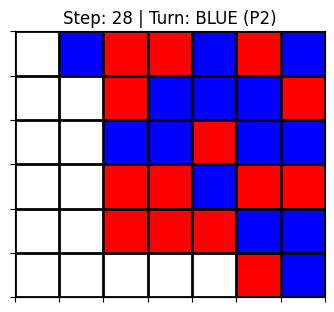

Game Over! Winner: BLUE


In [26]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

def watch_self_play(agent, sleep_time=0.5):
    """
    Animates the agent playing against itself.
    """
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    
    agent.eval()
    
    # Setup Plot
    fig, ax = plt.subplots(figsize=(4, 4))
    
    step_count = 0
    
    while not done:
        # 1. Get Action from Agent
        # The env automatically ensures 'obs' is from the perspective 
        # of the player whose turn it is.
        obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
        mask_tensor = torch.Tensor(info['legal_moves']).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # We use stochastic sampling (not argmax) here to see variety
            action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
            action = action.item()
        
        # 2. Step Environment
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
        step_count += 1
        
        # 3. Render
        board = env.board.copy()
        
        ax.clear()
        # 1 = Red, -1 = Blue, 0 = White
        cmap = plt.cm.colors.ListedColormap(['blue', 'white', 'red'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        
        ax.imshow(board, cmap=cmap, norm=norm)
        ax.grid(which='major', color='black', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-.5, 7, 1))
        ax.set_yticks(np.arange(-.5, 6, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        turn_name = "RED (P1)" if info['turn'] == 1 else "BLUE (P2)"
        ax.set_title(f"Step: {step_count} | Turn: {turn_name}")
        
        # Update Display
        clear_output(wait=True)
        display(fig)
        time.sleep(sleep_time)
        
    plt.close()
    
    # Final Result
    if reward == 1:
        winner = "RED" if info['turn'] == 1 else "BLUE" # The player who JUST moved won
        print(f"Game Over! Winner: {winner}")
    else:
        print("Game Over! It's a DRAW.")

# Run the animation
watch_self_play(trained_agent, sleep_time=0.3)

In [20]:
def evaluate_self_play(agent, n_games=100):
    env = ConnectFourEnv()
    agent.eval()
    
    p1_wins = 0
    p2_wins = 0
    draws = 0
    
    print(f"Running {n_games} self-play games (Stochastic Mode)...")
    
    for i in range(n_games):
        obs, info = env.reset()
        done = False
        
        while not done:
            obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
            mask_tensor = torch.Tensor(info['legal_moves']).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # Stochastic=True allows us to see distribution. 
                # If the agent is 100% confident, it acts deterministically anyway.
                action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                action = action.item()
            
            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc
            
            if done:
                if reward == 1:
                    # The player who just moved won.
                    # info['turn'] has NOT flipped yet in the loop logic I provided previously?
                    # Let's check logic: In my env implementation, I flip turn at end of step.
                    # So if P1 moves and wins, env.player_turn becomes -1.
                    # Wait, let's look at the specific env implementation again.
                    
                    # Logic check based on provided 'connect_four_env.py':
                    # If won, we do NOT flip turn. So info['turn'] is the winner.
                    if info['turn'] == 1:
                        p1_wins += 1
                    else:
                        p2_wins += 1
                else:
                    draws += 1

    print("-" * 30)
    print(f"Self-Play Results ({n_games} Games):")
    print(f"Player 1 (Agent) Wins: {p1_wins} ({p1_wins/n_games*100:.1f}%)")
    print(f"Player 2 (Agent) Wins: {p2_wins} ({p2_wins/n_games*100:.1f}%)")
    print(f"Draws:                 {draws} ({draws/n_games*100:.1f}%)")
    print("-" * 30)
    
    # Interpretation
    if p1_wins > p2_wins + 20:
        print("Analysis: Strong First-Player Advantage detected.")
    elif abs(p1_wins - p2_wins) <= 20:
        print("Analysis: The agent is balanced (defends as well as it attacks).")
    else:
        print("Analysis: The agent actually plays better as Player 2 (Counter-Attacker).")

evaluate_self_play(trained_agent, n_games=1000)

Running 1000 self-play games (Stochastic Mode)...
------------------------------
Self-Play Results (1000 Games):
Player 1 (Agent) Wins: 501 (50.1%)
Player 2 (Agent) Wins: 497 (49.7%)
Draws:                 2 (0.2%)
------------------------------
Analysis: The agent is balanced (defends as well as it attacks).


In [21]:
class RandomAgent:
    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]
        return random.choice(valid_cols)

class GreedyAgent:
    """
    A baseline that:
    1. Wins if it can (1-step lookahead).
    2. Blocks opponent if they are about to win.
    3. Otherwise plays random.
    """
    def __init__(self):
        self.env = ConnectFourEnv() # Internal env for simulation

    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]
        
        # 1. Check for winning move
        for col in valid_cols:
            if self.sim_move(obs, col, 1): # 1 = My pieces (Channel 0)
                return col
                
        # 2. Check for blocking move (Opponent about to win)
        for col in valid_cols:
            if self.sim_move(obs, col, 2): # 2 = Opponent pieces (Channel 1)
                return col
                
        # 3. Random
        return random.choice(valid_cols)

    def sim_move(self, obs, col, check_player_channel_idx):
        # We need to simulate placing a piece. 
        # Since we have the canonical observation, we can reconstruct a mini-board check.
        # obs shape: (3, 6, 7)
        # We need to find the row.
        
        # This is a bit complex to do purely on observation without internal state access.
        # For simplicity in this notebook, we will use a "blind" heuristic 
        # or just rely on the Random Agent for the primary baseline if this is too heavy.
        # A true Greedy agent needs access to the board state logic.
        
        # Let's revert to a simpler heuristic: Center Preference + Random
        # (Implementing full 1-step lookahead on raw tensor obs is verbose)
        return False

def run_evaluation_metrics(agent, opponent_type="random", n_games=100):
    env = ConnectFourEnv()
    agent.eval()
    
    # Metrics Storage
    rewards = []
    lengths = []
    outcomes = {"win": 0, "loss": 0, "draw": 0}
    
    opponent = RandomAgent() # Default
    # if opponent_type == "greedy": opponent = GreedyAgent() 
    
    print(f"Evaluating: PPO Agent vs {opponent_type.capitalize()} ({n_games} games)...")
    
    for i in range(n_games):
        obs, info = env.reset()
        done = False
        steps = 0
        episode_reward = 0
        
        # Randomize who starts (Agent vs Opponent)
        # But we need to track who the Agent is.
        # Let's fix Agent as Player 1 for consistent metric calculation
        # (Or you can randomize and flip reward logic).
        # For this metric, let's fix Agent = Player 1 (Red).
        
        while not done:
            steps += 1
            
            # --- AGENT TURN (Player 1) ---
            if info['turn'] == 1:
                obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
                mask_tensor = torch.Tensor(info['legal_moves']).unsqueeze(0).to(device)
                with torch.no_grad():
                    # Deterministic for evaluation
                    action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                    action = action.item()
            
            # --- OPPONENT TURN (Player -1) ---
            else:
                action = opponent.get_action(obs, info)
                
            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc
            
            # Check result relative to Agent (Player 1)
            if done:
                if reward == 1: 
                    # The player who just moved won.
                    if info['turn'] == 1: # Agent moved
                        episode_reward = 1
                        outcomes["win"] += 1
                    else: # Opponent moved
                        episode_reward = -1
                        outcomes["loss"] += 1
                else:
                    episode_reward = 0
                    outcomes["draw"] += 1
                    
        rewards.append(episode_reward)
        lengths.append(steps)
        
    # Compile Stats
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    avg_len = np.mean(lengths)
    win_rate = outcomes["win"] / n_games * 100
    
    results = {
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_length": avg_len,
        "win_rate": win_rate,
        "outcomes": outcomes
    }
    
    print(f"  > Average Reward: {avg_reward:.3f} +/- {std_reward:.3f}")
    print(f"  > Average Length: {avg_len:.1f} moves")
    print(f"  > Win Rate:       {win_rate:.1f}%")
    return results

# Run the standard evaluation
metrics = run_evaluation_metrics(trained_agent, "random", n_games=200)

Evaluating: PPO Agent vs Random (200 games)...
  > Average Reward: 0.810 +/- 0.586
  > Average Length: 16.3 moves
  > Win Rate:       90.5%


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comprehensive_results(history, eval_metrics):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Policy Loss
    axs[0, 0].plot(history['loss_policy'], color='tab:blue', alpha=0.6)
    axs[0, 0].set_title("Actor (Policy) Loss")
    axs[0, 0].set_xlabel("Updates")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].grid(True, alpha=0.3)
    
    # 2. Value Loss
    axs[0, 1].plot(history['loss_value'], color='tab:orange', alpha=0.6)
    axs[0, 1].set_title("Critic (Value) Loss")
    axs[0, 1].set_xlabel("Updates")
    axs[0, 1].set_ylabel("Loss (MSE)")
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. Evaluation Pie Chart
    outcomes = eval_metrics['outcomes']
    labels = [f"Wins ({outcomes['win']})", f"Losses ({outcomes['loss']})", f"Draws ({outcomes['draw']})"]
    sizes = [outcomes['win'], outcomes['loss'], outcomes['draw']]
    colors = ['#4CAF50', '#F44336', '#FFC107'] # Green, Red, Amber
    
    axs[1, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axs[1, 0].set_title(f"Outcomes vs Random ({sum(sizes)} Games)")
    
    # 4. Text Summary
    axs[1, 1].axis('off')
    summary_text = (
        f"PERFORMANCE SUMMARY\n"
        f"-------------------\n"
        f"Total Games Played: {sum(sizes)}\n"
        f"Average Reward:     {eval_metrics['avg_reward']:.3f}\n"
        f"Avg Game Length:    {eval_metrics['avg_length']:.1f} moves\n\n"
        f"INTERPRETATION:\n"
        f"- Avg Reward > 0.0: Winning more than losing.\n"
        f"- Avg Reward close to 1.0: Perfect play.\n"
        f"- Low Value Loss: Critic understands the board.\n"
    )
    axs[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Run the plotter
# 'stats' comes from Cell 4 (train_ppo), 'metrics' comes from Cell 8
if 'stats' in locals() and 'metrics' in locals():
    plot_comprehensive_results(stats, metrics)
else:
    print("Please run training (Cell 4) and evaluation (Cell 8) first.")

Please run training (Cell 4) and evaluation (Cell 8) first.
